# Ch 7. 機器學習應用
## 7-2. 序列資料處理

[7-2-1. 隱藏馬可夫模型](#sec7_2_1)  
[7-2-2. 條件隨機場](#sec7_2_2)
***

<a id='sec7_2_1'></a>
## 7-2-1. 隱藏馬可夫模型

In [1]:
states = ('下雨', '晴天')
observations = ('運動', '購物', '追劇')
start_prob = {'下雨': 0.6, '晴天': 0.4}
transition_prob = {
   '下雨' : {'下雨': 0.7, '晴天': 0.3},
   '晴天' : {'下雨': 0.4, '晴天': 0.6},
   }
emission_prob = {
   '下雨' : {'運動': 0.1, '購物': 0.4, '追劇': 0.5},
   '晴天' : {'運動': 0.6, '購物': 0.3, '追劇': 0.1},
   }

from hmmlearn import hmm
import numpy as np

model = hmm.MultinomialHMM(n_components=2)
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.7, 0.3],
                            [0.4, 0.6]])
model.emissionprob_ = np.array([[0.1, 0.4, 0.5],
                                [0.6, 0.3, 0.1]])
model

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=2,
               n_iter=10, params='ste', random_state=None, startprob_prior=1.0,
               tol=0.01, transmat_prior=1.0, verbose=False)

Q1: 根據上述的馬可夫模型，一個觀察序列發生的可能性為何？

In [2]:
import math

def obs_seq_likelyhood(seq):
    print('觀察序列 = (' + ','.join(seq) + '), ', end='')
    idx = [observations.index(x) for x in seq]
    prob = math.exp(model.score(np.array([idx])))
    print('可能性 = %.3f' % prob)

obs_seq_likelyhood(['運動'])
obs_seq_likelyhood(['追劇', '運動']) 
obs_seq_likelyhood(['追劇', '追劇', '追劇'])

觀察序列 = (運動), 可能性 = 0.300
觀察序列 = (追劇,運動), 可能性 = 0.091
觀察序列 = (追劇,追劇,追劇), 可能性 = 0.046


Q2: 給定一個馬可夫模型與一個觀察序列，最佳的隱藏狀態序列為何？

In [3]:
def opt_hidden_states(seq):
    idx = [observations.index(x) for x in seq]
    log_prob, seq = model.decode(np.array([idx]).transpose())
    print('可能性 = %.3f' % math.exp(log_prob))
    print('狀態 =', [states[i] for i in seq])

seq = ['追劇', '運動']
opt_hidden_states(seq)
seq = ['運動', '追劇', '購物']
opt_hidden_states(seq)

可能性 = 0.054
狀態 = ['下雨', '晴天']
可能性 = 0.013
狀態 = ['晴天', '下雨', '下雨']


<a id='sec7_2_2'></a>
## 7-2-2. 條件隨機場

### 參考資源：
- crfpp: https://github.com/taku910/crfpp
 - CRF++ 的多種語言實作，下載 example/chunging/train.data, test.data 作為本範例的訓練與測試資料
 - 執行完 nltk.download('conll2002') 後會顯示儲存路徑，將 train.data, test.data 放到該路徑內
- sklearn-crfsuite 官網：https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-use-conll-2002-data-to-build-a-ner-system

### 語料格式說明(train.data, test.data)：  
每一列有三行，分別為詞彙、詞性、實體類型(Named Entity Recognition, NER)，使用 Bakeoff-3 評測中採用 BIO 標註模式，即
- B, I, O 分別代表首字、中間字、標點符號
- NP, PP, VP ... 皆為詞性

#### 1. 讀取訓練集與測試集

In [4]:
import nltk
nltk.download('conll2002') # 下載通用語料 conll2002

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\yclin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2002.zip.


True

In [5]:
train_sents = list(nltk.corpus.conll2002.iob_sents('train.data'))
test_sents = list(nltk.corpus.conll2002.iob_sents('test.data'))
print(len(train_sents))
print(len(test_sents))

77
823


In [6]:
train_sents[0]

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'B-SBAR'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'B-ADJP'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

#### 2. 擷取特徵函數

In [7]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [8]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'confidence',
 'word[-3:]': 'nce',
 'word[-2:]': 'ce',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NN',
 'postag[:2]': 'NN',
 'BOS': True,
 '+1:word.lower()': 'in',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'IN',
 '+1:postag[:2]': 'IN'}

#### 3. 擷取特徵以建構訓練、測試集

In [9]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Wall time: 82.7 ms


#### 4. 建立 CRF 模型

In [10]:
%%time
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', # 預設值，採用 Elastic-net 迴歸模型
    c1=0.1,            # L1 懲罰項的係數
    c2=0.1,            # L2 懲罰項的係數 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 298 ms


C:\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

#### 5. 移除標點符號

In [11]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-NP',
 'B-PP',
 'I-NP',
 'B-VP',
 'I-VP',
 'B-SBAR',
 'B-ADJP',
 'B-ADVP',
 'I-ADVP',
 'I-ADJP',
 'I-SBAR',
 'I-PP',
 'B-PRT']

#### 6. 預測與效能評估

In [12]:
from sklearn_crfsuite import metrics

y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9061903371118709

In [13]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

      B-ADJP      0.549     0.453     0.497       172
      I-ADJP      0.611     0.139     0.227        79
      B-ADVP      0.651     0.760     0.702       334
      I-ADVP      0.343     0.333     0.338        36
        B-NP      0.933     0.920     0.927      5079
        I-NP      0.907     0.946     0.926      5691
        B-PP      0.915     0.940     0.927      1988
        I-PP      0.000     0.000     0.000        15
       B-PRT      1.000     0.026     0.050        39
      B-SBAR      0.635     0.552     0.591       192
      I-SBAR      0.000     0.000     0.000         2
        B-VP      0.933     0.927     0.930      1903
        I-VP      0.903     0.943     0.923      1061

   micro avg      0.905     0.913     0.909     16591
   macro avg      0.645     0.534     0.541     16591
weighted avg      0.903     0.913     0.906     16591



C:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 7. 超參數調校

In [14]:
%%time
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.6s finished


Wall time: 21 s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017A91E774C8>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017A91E77948>},
                   pre_dispatch='2*n_jobs', random_state=None, refi

視覺化檢驗參數(c1, c2)空間：紅色代表較好的效能，藍色則表現較差

Dark blue => 0.8604, dark red => 0.8865


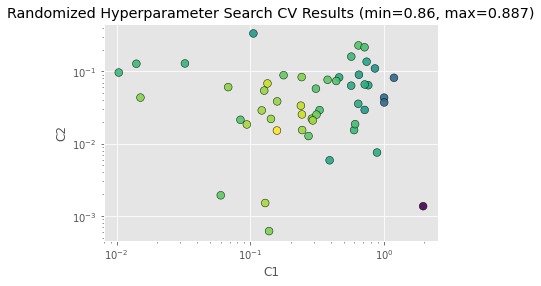

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

_x = list(rs.cv_results_['param_c1'])
_y = list(rs.cv_results_['param_c2'])
_c = list(rs.cv_results_['mean_test_score'])

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [16]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.15805651858859918, 'c2': 0.015179336202813924}
best CV score: 0.8865456143220861
model size: 0.06M


In [17]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

      B-ADJP      0.562     0.529     0.545       172
      I-ADJP      0.625     0.253     0.360        79
      B-ADVP      0.651     0.725     0.686       334
      I-ADVP      0.351     0.361     0.356        36
        B-NP      0.936     0.917     0.926      5079
        I-NP      0.902     0.946     0.923      5691
        B-PP      0.921     0.938     0.930      1988
        I-PP      0.000     0.000     0.000        15
       B-PRT      1.000     0.026     0.050        39
      B-SBAR      0.634     0.578     0.605       192
      I-SBAR      0.000     0.000     0.000         2
        B-VP      0.932     0.923     0.927      1903
        I-VP      0.903     0.941     0.922      1061

   micro avg      0.904     0.912     0.908     16591
   macro avg      0.647     0.549     0.556     16591
weighted avg      0.903     0.912     0.906     16591



C:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
